In [1]:
import pnet_loader
import util
import torch
import numpy as np
import os
import random
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA


%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
datapath='/mnt/disks/pancan/data/'
#datapath='../data/'

In [4]:
mutations_dict = {"3'Flank": 'Silent',
                  "5'Flank": 'Silent',
                  "5'UTR": 'Silent',
                  "3'UTR": 'Silent',
                  "IGR": 'Silent',
                  "Intron": 'Silent',
                  "lincRNA": 'Silent',
                  "RNA": 'Silent',
                  "Silent": 'Silent',
                  "non_coding_transcript_exon": 'Silent',
                  "upstream_gene": 'Silent',
                  "Splice_Region": 'Silent',
                  "Targeted_Region": 'Silent',
                  'Splice_Site': 'LOF',
                  'Nonsense_Mutation': 'LOF',
                  'Frame_Shift_Del': 'LOF',
                  'Frame_Shift_Ins': 'LOF',
                  'Stop_Codon_Del': 'LOF',
                  'Stop_Codon_Ins': 'LOF',
                  'Nonstop_Mutation': 'LOF',
                  'Start_Codon_Del': 'LOF',
                  'Missense_Mutation': 'Other_nonsynonymous',
                  'In_Frame_Del': 'Other_nonsynonymous',
                  'In_Frame_Ins': 'Other_nonsynonymous',
                  'De_novo_Start_InFrame': 'Other_nonsynonymous',
                  'De_novo_Start_OutOfFrame': 'Other_nonsynonymous',
                  'Start_Codon_Ins': 'Other_nonsynonymous'
                  }

## Load mutation data

In [5]:
maf = pd.read_csv(datapath+'/m1000/M1000_CCF.maf', sep='\t')
survival_data = pd.read_csv(datapath+'m1000/M1000_survival_data.txt', sep='\t').set_index('Tumor_Sample_Barcode')
clinical_mapping = pd.read_csv(datapath+'/m1000/TCGA_clinical_mapping_and_pathologic_M.txt', sep='\t').set_index('Tumor_Sample_Barcode')

maf = maf[maf['Tumor_Sample_Barcode'].isin(clinical_mapping.index)].copy()
maf['Variant_Classification'] = [mutations_dict[m] for m in maf['Variant_Classification']]
maf = maf[maf['Variant_Classification'] != 'Silent'].copy()

maf_grouped = maf.groupby('Tumor_Sample_Barcode')['Hugo_Symbol'].apply(set).reset_index(name='mut_list').set_index('Tumor_Sample_Barcode')
mutations = pd.DataFrame(columns = maf['Hugo_Symbol'].unique(), index = maf_grouped.index)
mutations.fillna(0, inplace = True)

for i, p in maf_grouped.iterrows():
    for mut in p['mut_list']:
        mutations.loc[i][mut] = 1

mutations = mutations.join(clinical_mapping[['mapping_patient_id']], how='inner').set_index('mapping_patient_id')

## Load expression data

In [6]:
skcm_exp = pd.read_csv(datapath+'skcm_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt',
                       sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
skcm_exp.index = ['-'.join(ind.split('-')[:-1]) for ind in skcm_exp.index]

In [7]:
# non_constant_genes = util.select_non_constant_genes(skcm_exp)
# highly_variable_genes = util.select_highly_variable_genes(skcm_exp)['Hugo_Symbol'].values
# selected_genes = ['TP53', 'AR', 'PTEN', 'NOTCH1']
# genes = list(set(highly_variable_genes).intersection(non_constant_genes)) + selected_genes
# skcm_exp = skcm_exp[genes].copy()

## Load prediction target

In [8]:
# mat_TCGA = pd.read_csv(datapath+'m1000/mat_TCGA.tsv', sep='\t').set_index('Tumor_Sample_Barcode')

# mat_TCGA = mat_TCGA.join(clinical_mapping[['mapping_patient_id']], how='inner').set_index('mapping_patient_id')

# heterogeneity_y = pd.DataFrame(index=mat_TCGA.index, columns=['dichtomized_heterogeneity'],
#                                data=[int(p > mat_TCGA['heterogeneity'].median()) 
#                                      for p in mat_TCGA['heterogeneity'].values])

In [9]:
absolute_TCGA = pd.read_csv(datapath+'/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt', delimiter='\t')
absolute_TCGA['array'] =  absolute_TCGA['array'].apply(lambda x: x[:-3])
absolute_TCGA.set_index('array', inplace=True)
absolute_TCGA = absolute_TCGA.loc[list(set(absolute_TCGA.index).intersection(skcm_exp.index))].copy()
absolute_TCGA.dropna(inplace=True)
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_TCGA['ploidy'].values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_TCGA['ploidy'].max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_TCGA['ploidy'].max(),1000)[y[:,1] < 0.5].max()
ma = 2.23
absolute_ploidy_y = pd.DataFrame(index=absolute_TCGA.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in absolute_TCGA['ploidy'].values])

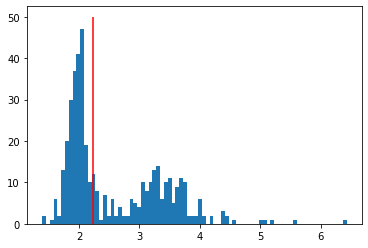

In [10]:
plt.hist(absolute_TCGA['ploidy'], bins=80)
plt.vlines([ma], color='r', ymin=0, ymax=50)
plt.show()

In [11]:
# heterogeneity_y_ex = pd.qcut(mat_TCGA['heterogeneity'], 3, labels=['low', 'mid', 'high'])
# heterogeneity_y_ex = heterogeneity_y_ex[heterogeneity_y_ex!='mid']
# heterogeneity_y_ex = pd.DataFrame(index=heterogeneity_y_ex.index, columns=['dichtomized_heterogeneity'],
#                                data=[int(p == 'high') 
#                                      for p in heterogeneity_y_ex])

## Validation with Liu cohort

In [12]:
sample_mapping = pd.read_csv(datapath+'/mel_dfci_2019/data_clinical_sample.txt', sep='\t').set_index('#Patient Identifier')
liu_ploidy = pd.DataFrame(sample_mapping['Ploidy']).iloc[4:].astype(float)
liu_ploidy_y = pd.DataFrame(index=liu_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in liu_ploidy['Ploidy'].values])

In [13]:
liu_maf = pd.read_csv(datapath+'mel_dfci_2019/all_muts_12_1_2020_ref_alt_counts_added.maf', sep='\t')
liu_clinical_mapping = pd.read_csv(datapath+'/mel_dfci_2019/data_clinical_sample.txt',
                                   sep='\t').set_index('#Patient Identifier')

liu_maf = liu_maf[liu_maf['Patient'].isin(liu_clinical_mapping.index)].copy()
liu_maf['Variant_Classification'] = [mutations_dict[m] for m in liu_maf['Variant_Classification']]
liu_maf = liu_maf[liu_maf['Variant_Classification'] != 'Silent'].copy()

liu_maf_grouped = liu_maf.groupby('Patient')['Hugo_Symbol'].apply(set).reset_index(name='mut_list').set_index('Patient')
liu_mutations = pd.DataFrame(columns = liu_maf['Hugo_Symbol'].unique(), index = liu_maf_grouped.index)
liu_mutations.fillna(0, inplace = True)

for i, p in liu_maf_grouped.iterrows():
    for mut in p['mut_list']:
        liu_mutations.loc[i][mut] = 1

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
liu_rna = pd.read_csv(datapath+'mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
liu_rna = sample_mapping[['Sample Identifier']].join(liu_rna, on='Sample Identifier',
                                                     how='inner').drop('Sample Identifier', axis=1)
genes = list(set.intersection(set(skcm_exp.columns), set(mutations.columns), set(liu_rna.columns), set(liu_mutations.columns)))
skcm_exp = skcm_exp[genes].copy()
liu_rna = liu_rna[genes].copy()

## Select informative Genes

In [15]:
# pca = PCA(n_components=50)
# pca.fit(skcm_exp.values)

# pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=skcm_exp.columns)

# genes_pca = abs(pca_loadings).sum(axis=1).nlargest(3000).index

# If using pre-run data:
gimp = pd.read_csv('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/run0/gene_importances.csv').set_index('Unnamed: 0')
genes_pca = list(gimp.columns)

## Generate folds

In [16]:
genetic_data = {'rna': skcm_exp[genes_pca], 'mut': mutations}

In [17]:
# melanoma_inds = pnet_loader.get_indicies(genetic_data, absolute_ploidy_y)
# random.shuffle(melanoma_inds)

# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]
        
# test_splits = chunks(melanoma_inds, int(len(melanoma_inds)/10)+1)
# for i, s in enumerate(test_splits):
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y, test_inds=s)
#     train_dataset.save_indicies(datapath+'splits/melanoma_ploidy/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies(datapath+'splits/melanoma_ploidy/test_set_{}.csv'.format(i))

## Train with run()

In [18]:
import Pnet

In [19]:
genetic_data = {'rna': skcm_exp[genes_pca], 'mut': mutations}
val_genetic_data = {'rna': liu_rna[genes_pca], 'mut': liu_mutations}

In [20]:
val_inds = pnet_loader.get_indicies(val_genetic_data, liu_ploidy_y)
val_dataset = pnet_loader.PnetDataset(val_genetic_data, liu_ploidy_y, val_inds)

Found 121 overlapping indicies
Found 3000 overlapping genes
generated input DataFrame of size (121, 6000)


In [21]:
# for i in range(10):
#     train_inds = list(pd.read_csv(datapath+'splits/melanoma_ploidy/train_set_{}.csv'.format(i))['indicies'])
#     test_inds = list(pd.read_csv(datapath+'splits/melanoma_ploidy/test_set_{}.csv'.format(i))['indicies'])
#     model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, absolute_ploidy_y, seed=0,
#                                                                              dropout=0.3, lr=1e-4, weight_decay=1,
#                                                                              batch_size=64, epochs=300, early_stopping=True,
#                                                                              train_inds=train_inds, test_inds=test_inds)
#     print('class balance train: ', train_dataset.y.mean())
#     print('class balance test: ', test_dataset.y.mean())
#     plt.clf()
#     Pnet.evaluate_interpret_save(model, test_dataset, '/mnt/disks/pancan/pnet/results/ploidy/tcga_skcm/run{}'.format(i))
#     plt.clf()
#     Pnet.evaluate_interpret_save(model, val_dataset, '/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/run{}'.format(i))

In [22]:
tcga_aucs = []
for i in range(10):
    auc = torch.load('/mnt/disks/pancan/pnet/results/ploidy/tcga_skcm/run{}/AUC.pt'.format(i))
    tcga_aucs.append(auc.item())

In [23]:
liu_aucs = []
for i in range(10):
    auc = torch.load('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/run{}/AUC.pt'.format(i))
    liu_aucs.append(auc.item())

In [24]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

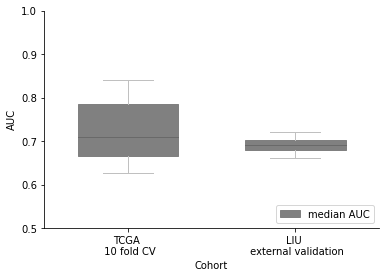

In [25]:
plt.clf()
auc_df = pd.DataFrame({'TCGA \n 10 fold CV': tcga_aucs, 'LIU \n external validation': liu_aucs})
auc_df.boxplot(showfliers=False,
           color=dict(boxes='grey', whiskers='silver', medians='dimgray', caps='silver'), widths=0.6, patch_artist=True)
plt.ylim((0.5,1))
plt.grid(False)
plt.legend(['median AUC'], loc='lower right')
plt.ylabel('AUC')
plt.xlabel('Cohort')
plt.savefig('SKCM_ploidy_TCGA_vs_Liu.pdf')
plt.show()

In [29]:
auc_df['TCGA \n 10 fold CV'].median()

0.710014134645462

In [31]:
auc_df

,TCGA \n 10 fold CV,LIU \n external validation
0,0.636364,0.710046
1,0.696471,0.680651
2,0.803204,0.701769
3,0.663616,0.697203
4,0.736111,0.704338
5,0.723558,0.662386
6,0.840278,0.680651
7,0.627160,0.671233
8,0.673611,0.722032
9,0.836420,0.685217


In [32]:
auc_df['LIU \n external validation'].median()

0.6912100613117218

In [33]:
# for i in range(10):
#     skcm_path = '/mnt/disks/pancan/pnet/results/ploidy/tcga_skcm_rf/run{}'.format(i)
#     val_path = '/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm_rf/run{}'.format(i)
#     if not os.path.exists(skcm_path):
#         os.makedirs(skcm_path)
#     if not os.path.exists(val_path):
#         os.makedirs(val_path)
#     train_inds = list(pd.read_csv(datapath+'splits/melanoma_ploidy/train_set_{}.csv'.format(i))['indicies'])
#     test_inds = list(pd.read_csv(datapath+'splits/melanoma_ploidy/test_set_{}.csv'.format(i))['indicies'])
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=absolute_ploidy_y, train_inds=train_inds, test_inds=test_inds)
    
#     x_train = train_dataset.x
#     additional_train = train_dataset.additional
#     y_train = train_dataset.y.ravel()
#     x_test = test_dataset.x
#     additional_test = test_dataset.additional
#     y_test = test_dataset.y.ravel()
#     x_val = val_dataset.x
#     additional_val = val_dataset.additional
#     y_val = val_dataset.y.ravel()
    
#     rfc = RandomForestClassifier(max_depth=None, random_state=0)
#     rfc.fit(x_train, y_train)
#     preds = rfc.predict(x_test)
#     preds_prob = rfc.predict_proba(x_test)
#     plt.clf()
#     auc = util.get_auc(torch.tensor(preds_prob, dtype=torch.float), y_test, save=skcm_path+'/auc_curve.pdf')
#     importances = rfc.feature_importances_
#     forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
#     forest_importances.to_csv(skcm_path+'/gene_feature_importances.csv')
#     torch.save(auc, skcm_path+'/AUC.pt')
    
#     preds = rfc.predict(x_val)
#     preds_prob = rfc.predict_proba(x_val)
#     plt.clf()
#     auc = util.get_auc(torch.tensor(preds_prob, dtype=torch.float), y_val, save=val_path+'/auc_curve.pdf')
#     importances = rfc.feature_importances_
#     forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
#     forest_importances.to_csv(val_path+'/gene_feature_importances.csv')
#     torch.save(auc, val_path+'/AUC.pt')

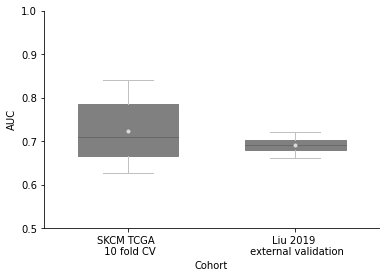

In [50]:
tcga_rf_aucs = []
for i in range(10):
    auc = torch.load('/mnt/disks/pancan/pnet/results/ploidy/tcga_skcm_rf/run{}/AUC.pt'.format(i))
    tcga_rf_aucs.append(auc.item())

liu_rf_aucs = []
for i in range(10):
    auc = torch.load('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm_rf/run{}/AUC.pt'.format(i))
    liu_rf_aucs.append(auc.item())
    
plt.clf()
auc_df = pd.DataFrame({'SKCM TCGA \n 10 fold CV': tcga_aucs, 'Liu 2019 \n external validation': liu_aucs,
                       #'RF TCGA \n 10 fold CV': tcga_rf_aucs, 'RF LIU \n external validation': liu_rf_aucs
                      })
auc_df.boxplot(showfliers=False,
           color=dict(boxes='grey', whiskers='silver', medians='dimgray', caps='silver'), widths=0.6, patch_artist=True, showmeans=True, 
               meanprops={"marker":".","markerfacecolor":"gainsboro", "markeredgecolor":"gainsboro"})
plt.ylim((0.5,1))
plt.grid(False)
plt.ylabel('AUC')
plt.xlabel('Cohort')
plt.savefig('SKCM_ploidy_TCGA_vs_Liu.pdf', bbox_inches='tight')
plt.show()

In [51]:
pnet_df_imp = pd.DataFrame()
pnet_df_rnk = pd.DataFrame()
for i in range(10):
    gene_imps = pd.read_csv('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/run{}/gene_importances.csv'.format(i))
    pnet_df_imp['run_{}'.format(i)] = gene_imps.set_index('Unnamed: 0').mean()
    pnet_df_rnk['run_{}'.format(i)] = gene_imps.set_index('Unnamed: 0').mean().rank(ascending=False)

pnet_rank_var = pnet_df_rnk.loc[pnet_df_rnk.mean(axis=1).nsmallest(50).index].std(axis=1).median()
print('Varience in ranking: ',pnet_rank_var)
pnet_imps = pnet_df_imp.mean(axis=1)

Varience in ranking:  33.0993805738452


In [52]:
rf_df_imp = pd.DataFrame()
rf_df_rnk = pd.DataFrame()
for i in range(10):
    gene_imps = pd.read_csv('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm_rf/run{}/gene_feature_importances.csv'.format(i))
    gene_imps = gene_imps.set_index('Unnamed: 0')
    gene_imps = pd.DataFrame(gene_imps.values.reshape((2, 3000)).T.sum(axis=1),
                             index=gene_imps.index[:3000],
                             columns=['gene_imp'])
    rf_df_imp['run_{}'.format(i)] = gene_imps
    rf_df_rnk['run_{}'.format(i)] = gene_imps.rank(ascending=False)
rf_rank_var = rf_df_rnk.loc[rf_df_rnk.mean(axis=1).nsmallest(50).index].std(axis=1).nsmallest(100).median()
print('Varience in ranking: ',rf_rank_var)
rf_imps = rf_df_imp.mean(axis=1)

Varience in ranking:  526.8532719930056


In [53]:
gene_ordering = list(pnet_df_rnk.mean(axis=1).nlargest(10).index) + list(pnet_df_rnk.mean(axis=1).nsmallest(10).index)[::-1]

<AxesSubplot:>

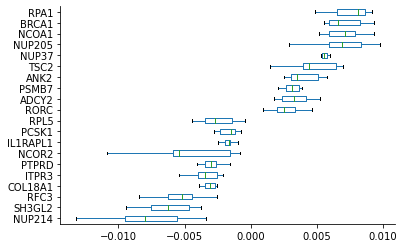

In [54]:
pnet_df_imp.loc[gene_ordering].T.boxplot(vert=False, showfliers=False, grid=False)

<AxesSubplot:>

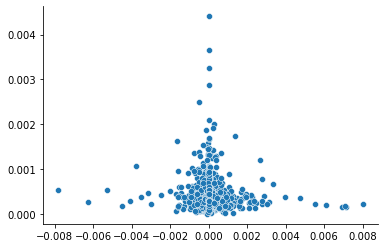

In [55]:
sns.scatterplot(x=pnet_imps, y=rf_imps)

In [56]:
import ReactomeNetwork

In [57]:
reactome_network = ReactomeNetwork.ReactomeNetwork(val_dataset.get_genes())
reactome_network.pathway_encoding.loc[reactome_network.pathway_encoding.shape[0]] = ['root', 'Outcome', 'Homo sapiens']
gene_layers, pathway_layers = reactome_network.get_layers(trim=1)

for gl in gene_layers:
    gl.columns = [reactome_network.pathway_encoding.set_index('ID').loc[col]['pathway'] for col in gl.columns]
    
for pl in pathway_layers:
    pl.index = [reactome_network.pathway_encoding.set_index('ID').loc[col]['pathway'] for col in pl.index]
    pl.columns = [reactome_network.pathway_encoding.set_index('ID').loc[col]['pathway'] for col in pl.columns]
gene_layers[1] = gene_layers[1].loc[:,~gene_layers[1].columns.duplicated()].copy()

Found 3000 overlapping genes


In [75]:
some_list = pathway_layers[1:5]
some_list.insert(0, gene_layers[1])

In [76]:
all_things = ['Outcome']
for l in some_list:
    all_things.extend(l.index)
all_things.extend(['Residual0', 'Residual1', 'Residual2', 'Residual3', 'Residual4', 'Gene Expression', 'Mutations'])
all_things = list(set(all_things))

In [77]:
d = dict((j,i) for i,j in enumerate(all_things))
d_inv = dict((v,k) for k,v in d.items())

In [78]:
gene_feature_imps = pd.read_csv('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/run0/gene_feature_importances.csv').set_index('Unnamed: 0')

mod_imp = pd.DataFrame(data={'exp_imp': gene_feature_imps.sum().values[:3000], 'mut_imp': gene_feature_imps.sum().values[3000:]}).mean()


In [79]:
layers = []
for i in range(4):
    layer_df_imp = pd.DataFrame()
    for j in range(10):
        layer_imps = pd.read_csv('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/run{}/layer_{}_importances.csv'.format(j,i))
        layer_df_imp['run_{}'.format(i)] = layer_imps.set_index('Unnamed: 0').mean()
    layer_imps = layer_df_imp.mean(axis=1)
    layers.append(layer_imps)
layers = [pd.DataFrame(l, columns=['importance']) for l in layers]
for i, l in enumerate(layers):
    l['rank'] = l['importance'].rank(ascending=False)
    l['level'] = i + 1
gene_imps = pd.DataFrame(pnet_imps, columns=['importance'])
gene_imps['rank'] = gene_imps['importance'].rank(ascending=False)
gene_imps['level'] = 0
layers.append(gene_imps)
layers = pd.concat(layers)

mean_imp = layers[layers['rank'] < 10]['importance'].mean()
layers.loc['Residual4'] = [mean_imp, 0, 4]
layers.loc['Residual3'] = [mean_imp, 0, 3]
layers.loc['Residual2'] = [mean_imp, 0, 2]
layers.loc['Residual1'] = [mean_imp, 0, 1]
layers.loc['Residual0'] = [mean_imp, 0, 0]
layers.loc['Outcome'] = [1, 0, 5]
layers.loc['Gene Expression'] = [mod_imp['exp_imp'], 0, -1]
layers.loc['Mutations'] = [mod_imp['mut_imp'], 0, -1]

In [103]:
s, t, v = [], [], []
for l in some_list:
    cols = l.columns
    for c in cols:
        rows = l[l[c] > 0].index
        for r in rows:
            # Only add important enough connections
            if layers.loc[r]['rank'] < 6 and layers.loc[c]['rank'] < 6:
                s.append(d[r])
                t.append(d[c])
                v.append(layers.loc[r]['importance'])
                
                # Add residual inflow edges to higher level pathways if they haven't any
                if layers.loc[r]['level'] > 0 and d[r] not in t:
                    res = 'Residual{}'.format(int(layers.loc[r]['level'])-1)
                    s.append(d[res])
                    t.append(d[r])
                    v.append(layers.loc[res]['importance'])
                    
                # Add input modality connection to genes
                if layers.loc[r]['level'] == 0:
                    s.append(d['Gene Expression'])
                    t.append(d[r])
                    v.append(layers.loc['Gene Expression']['importance'])
                    
                    s.append(d['Mutations'])
                    t.append(d[r])
                    v.append(layers.loc['Mutations']['importance'])
                    
            #TODO!!!!
                
            # Add edges of final pathway layer if they have inflow    
            if layers.loc[r]['level'] == 4 and d[r] not in s:
                if d[r] in t:
                    s.append(d[r])
                    t.append(d[c])
                    v.append(layers.loc[r]['importance'])
            
# Add residual outflow edges to lower level pathways 
t_copy = t.copy()
for t_ in t_copy:
    if layers.loc[d_inv[t_]]['level'] < 5 and t_ not in s:
        res = 'Residual{}'.format(int(layers.loc[d_inv[t_]]['level'])+1)
        s.append(t_)
        t.append(d[res])
        v.append(layers.loc[res]['importance'])
        if t_ == 4214:
            raise Exception('I know Python! 4')

In [104]:
for i in range(4):
    res_s = 'Residual{}'.format(i)
    res_t = 'Residual{}'.format(i+1)
    s.append(d[res_s])
    t.append(d[res_t])
    v.append(layers.loc[res_s]['importance'])

s.append(d['Residual4'])
t.append(d['Outcome'])
v.append(layers.loc['Residual4']['importance'])

s.append(d['Gene Expression'])
t.append(d['Residual0'])
v.append(layers.loc['Gene Expression']['importance'])

s.append(d['Mutations'])
t.append(d['Residual0'])
v.append(layers.loc['Mutations']['importance'])

In [109]:
short_names = pd.read_csv('/mnt/disks/pancan/data/pathways_short_names.csv').set_index('Full name')
short_names = pd.DataFrame(short_names['Short name (Eli)'].fillna(short_names['Short name (automatic)']))
for i in range(5):
    short_names.loc['Residual{}'.format(i)] = ['Residual']

for elem in list(d.keys()):
    if elem not in short_names.index:
        short_names.loc[elem] = [elem]

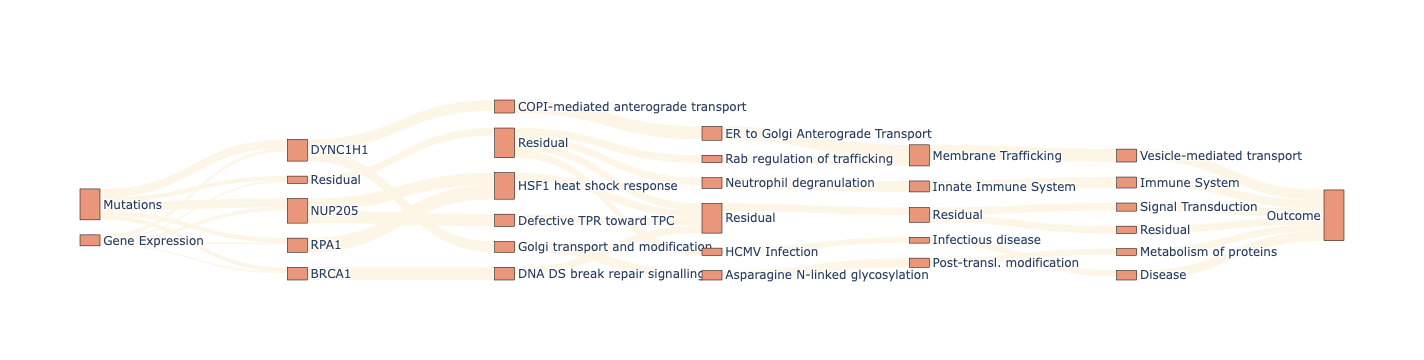

In [110]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = np.reshape(short_names.loc[list(d.keys())].values, -1),
      color = "darksalmon"
    ),
    link = dict(
      source = s, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = t,
      value = v,
        color = "oldlace"
  ))])

fig.show()

from pathlib import Path

with Path("ploidy_sankey_diagram.html").open("w") as f:
    f.write(fig.to_html())


In [101]:
layers[(layers['level']==2) & (layers['rank']<6)]

,importance,rank,level
ER to Golgi Anterograde Transport,0.007764,1.0,2.0
Asparagine N-linked glycosylation,0.005163,3.0,2.0
HCMV Infection,0.003021,5.0,2.0
Rab regulation of trafficking,0.004124,4.0,2.0
Neutrophil degranulation,0.006091,2.0,2.0
Residual2,0.004169,0.0,2.0


In [102]:
layers.loc['DNA Double Strand Break Response']

importance    0.002434
rank          9.000000
level         2.000000
Name: DNA Double Strand Break Response, dtype: float64

In [110]:
d_inv[t[1]]

'G1/S Transition'

In [113]:
d['G1/S Transition']

4214

In [112]:
layers.loc['G1/S Transition']

importance     0.000704
rank          51.000000
level          1.000000
Name: G1/S Transition, dtype: float64

In [ ]:
d_inv[24]

In [ ]:
list(zip(s, t))

In [ ]:
list(d.keys())[1464]

In [ ]:
layers.loc['Neutrophil degranulation']['level']

In [ ]:
pnet_df_imp = pd.DataFrame()
pnet_df_rnk = pd.DataFrame()
for i in range(10):
    gene_imps = pd.read_csv('/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/run{}/gene_importances.csv'.format(i))
    pnet_df_imp['run_{}'.format(i)] = gene_imps.set_index('Unnamed: 0').mean()
    pnet_df_rnk['run_{}'.format(i)] = gene_imps.set_index('Unnamed: 0').mean().rank(ascending=False)

pnet_rank_var = pnet_df_rnk.loc[pnet_df_rnk.mean(axis=1).nsmallest(50).index].std(axis=1).median()
print('Varience in ranking: ',pnet_rank_var)
pnet_imps = pnet_df_imp.mean(axis=1)

In [ ]:
gene_ordering = list(pnet_imps.nlargest(10).index) + list(pnet_imps.nsmallest(10).index)



In [ ]:
rf_imps.nlargest(10)

In [ ]:
import gseapy as gp
ss = gp.ssgsea(data=pd.DataFrame(pnet_imps), 
               gene_sets='/mnt/disks/pancan/pnet/data/reactome/ReactomePathways.gmt', 
               outdir='/mnt/disks/pancan/pnet/results/ploidy/liu_val_skcm/ssgsea')
pathway_scores = ss.res2d.pivot(index='Term', columns='Name', values='NES').T

In [ ]:
pathway_scores.T['0'].astype(float).nlargest(20)

In [ ]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=True)

        x_test = test_dataset.x
        additional_test = test_dataset.additional
        y_test = test_dataset.y

        model.to('cpu')
        pred = model(x_test, additional_test).detach()
        auc = util.get_auc(pred, y_test)
        aucs.append(auc)
        _, _, gene_importances, _ = model.interpret(test_dataset)
        most_imp_genes.append(gene_importances)
    return aucs, most_imp_genes

In [ ]:
#heterogeneity_auc, heterogeneity_genes = fold_run(genetic_data, heterogeneity_y, 10)
#heterogeneity_ex_auc, heterogeneity_ex_genes = fold_run(genetic_data, heterogeneity_y_ex, 10)
#ploidy_auc, ploidy_genes = fold_run(genetic_data, ploidy_y, 10)
ploidy_absolue_auc, ploidy_absolute_genes = fold_run(genetic_data, absolute_ploidy_y, 10)

In [ ]:
plt.boxplot([ploidy_absolue_auc],
            labels=['ploidy \n absolute'])
plt.show()

In [ ]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.values
        additional_train = train_dataset.additional_data.values
        y_train = train_dataset.target.values.reshape(-1)
        x_test = test_dataset.input_df.values
        additional_test = test_dataset.additional_data.values
        y_test = test_dataset.target.values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns).nlargest(20, 0))
    return aucs, most_imp_genes

In [ ]:
heterogeneity_auc, heterogeneity_genes_rf = fold_run_rf(genetic_data, heterogeneity_y, 10)
heterogeneity_ex_auc_rf, heterogeneity_ex_genes_rf = fold_run_rf(genetic_data, heterogeneity_y_ex, 10)
ploidy_auc_rf, ploidy_genes_rf = fold_run_rf(genetic_data, ploidy_y, 10)
ploidy_ex_auc_rf, ploidy_ex_genes_rf = fold_run_rf(genetic_data, ploidy_y_ex, 10)

In [ ]:
data_pnet = [heterogeneity_auc, heterogeneity_ex_auc, ploidy_auc, ploidy_ex_auc]
data_rf = [heterogeneity_auc_rf, heterogeneity_ex_auc_rf, ploidy_auc_rf, ploidy_ex_auc_rf]

ticks = ['heterogeneity', 'heterogeneity \n extremes', 'ploidy', 'ploidy \n extremes']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('heterogeneity_ploidy_auc_pnet_vs_rf.pdf')

In [ ]:
ploidy_genes[0].index

In [ ]:
gene_count_dict = {}
for r in ploidy_genes:
    for g in r.index:
        try:
            gene_count_dict[g] += 1
        except KeyError:
            gene_count_dict[g] = 1
pd.DataFrame.from_dict(gene_count_dict, orient='index').nlargest(10, 0)

In [ ]:
gene_count_dict = {}
for r in ploidy_genes_rf:
    for g in r.index:
        try:
            gene_count_dict[g] += 1
        except KeyError:
            gene_count_dict[g] = 1
pd.DataFrame.from_dict(gene_count_dict, orient='index').nlargest(10, 0)

In [ ]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)

In [ ]:
plt.boxplot(ploidy_absolut_auc,
            labels=['absolute \n ploidy'])
plt.show()

In [ ]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         heterogeneity_y,
                                                                         verbose=False,
                                                                         early_stopping=False)

In [ ]:
x_train = train_dataset.input_df.values
additional_train = train_dataset.additional_data.values
y_train = train_dataset.target.values.reshape(-1)
x_test = test_dataset.input_df.values
additional_test = test_dataset.additional_data.values
y_test = test_dataset.target.values.reshape(-1)

In [ ]:
pred = model(torch.tensor(x_test, dtype=torch.float),
                          torch.tensor(additional_test, dtype=torch.float)
            )
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_heterogeneity_ROC_curve.pdf')
plt.show()

# Interpretability

## Gene level

### General correlations

In [ ]:
from scipy.stats import pearsonr

In [ ]:
input_df = pd.concat([train_dataset.input_df, test_dataset.input_df]).iloc[:,:int(1376/2)]
target_df = mat_TCGA.loc[input_df.index]
corr = []
for col in input_df.columns:
    r, p = pearsonr(input_df[col], target_df['ploidy'])
    corr.append((r,p))
heterog_corr = pd.DataFrame(corr, columns=['R', 'p_val'], index=input_df.columns)
heterog_corr['-log10_pval'] = -np.log10(heterog_corr['p_val'])

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(heterog_corr, x='R', y='-log10_pval', ax=ax)
ax.axhline(y=-np.log10(0.05/heterog_corr.shape[0]), color='r', linestyle='--')


for gene in heterog_corr.index:
    if heterog_corr.loc[gene]['-log10_pval'] > -np.log10(0.05/heterog_corr.shape[0]):
        ax.annotate(gene, (heterog_corr.loc[gene]['R'], heterog_corr.loc[gene]['-log10_pval']))
fig.suptitle('Ploidy correlation of genes')
fig.savefig('Ploidy_correlation_genes.pdf')

In [ ]:
heterog_corr.nlargest(10, 'R')

### Pnet importances

In [ ]:
gene_importances, additional_importances = model.deepLIFT(test_dataset)

In [ ]:
gene_imp_by_target = gene_importances.join(test_dataset.target).groupby('dichtomized_heterogeneity').mean().T
gene_imp_by_target['diff'] = abs(gene_imp_by_target[0] - gene_imp_by_target[1])

In [ ]:
gene_imp_by_target[abs(gene_imp_by_target['diff']) > 0].nlargest(10, 'diff')

In [ ]:
gene_importances.sum().nlargest(20)

In [ ]:
gene_impacts = pd.DataFrame()
gene_impacts['gene'] = rn.gene_list
gene_impacts['impact'] = gene_impacts['gene'].apply(lambda x: sum([l.loc[x].sum() for l in rn.gene_layers]))
gene_impacts['impact'].mean()

In [ ]:
gene_impacts.nlargest(20, 'impact')

In [ ]:
flat_list = [item.split('_')[0] for sublist in altered_genes for item in sublist]
df = pd.DataFrame(index=flat_list)
df['gene_impact'] = gene_impacts.set_index('gene').loc[flat_list]['impact']
df['auc'] = aucs
df['most_imp_gene'] = most_imp_genes
df

In [ ]:
df = df.reset_index(names='gene')

In [ ]:
df_2 = pd.DataFrame()
df_2['gene_1'] = [x[0].split('_')[0] for x in altered_genes_2]
df_2['gene_2'] = [x[1].split('_')[0] for x in altered_genes_2]
df_2['gene_1_impact'] = gene_impacts.set_index('gene').loc[df_2['gene_1'].values]['impact'].values
df_2['gene_2_impact'] = gene_impacts.set_index('gene').loc[df_2['gene_2'].values]['impact'].values
df_2['auc_2'] = aucs_2
df_2['most_imp_gene_2'] = most_imp_genes_2
df_2

In [ ]:
df.join(df_2)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(df.join(df_2)[['auc','auc_2']])
ax.set_xticklabels(['1 target gene','2 target genes'])
plt.savefig('AUC_with_perfectly_correlated_genes.pdf')

## Compare with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))

In [ ]:
test_acc = sum(clf.predict(test_dataset.input_df.values) == test_dataset.target.values.reshape(-1))/len(test_dataset)
test_acc

In [ ]:
pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns).nlargest(10, 0)

In [ ]:
plot_df = skcm_exp.join(heterogeneity_y)
sns.histplot(plot_df, x='ZACN', hue='dichtomized_heterogeneity', bins=80)


In [ ]:
importances_df = pd.DataFrame(index=heterog_corr.index)
importances_df['corr'] = heterog_corr['R']
importances_df['pnet_diff'] = gene_imp_by_target['diff'].loc[heterog_corr.index]
importances_df['pnet_sum'] = gene_importances.sum().loc[heterog_corr.index]

In [ ]:
sns.scatterplot(importances_df, x='corr', y='pnet_diff')


In [ ]:
sns.scatterplot(importances_df, x='corr', y='pnet_sum')
plt.savefig('pnet_importance_vs_correlation.pdf')

In [ ]:
sns.scatterplot(importances_df, x='pnet_diff', y='pnet_sum')

## Pathway level

### General correlations

In [ ]:
import gseapy as gp

In [ ]:
ss = gp.ssgsea(data=input_df.T, 
               gene_sets='../data/reactome/ReactomePathways.gmt', 
               outdir='../ssgsea')

In [ ]:
pathway_scores = ss.res2d.pivot(index='Term', columns='Name', values='NES').T

In [ ]:
target_df = mat_TCGA.loc[input_df.index]
corr = []
for col in pathway_scores.columns:
    r, p = pearsonr(pathway_scores[col], target_df['heterogeneity'])
    corr.append((r,p))
heterog_pathway_corr = pd.DataFrame(corr, columns=['R', 'p_val'], index=pathway_scores.columns)
heterog_pathway_corr['-log10_pval'] = -np.log10(heterog_pathway_corr['p_val'])

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(heterog_pathway_corr, x='R', y='-log10_pval', ax=ax)
ax.axhline(y=-np.log10(0.05/heterog_pathway_corr.shape[0]), color='r', linestyle='--')


for gene in heterog_pathway_corr.index:
    if heterog_pathway_corr.loc[gene]['-log10_pval'] > -np.log10(0.05/heterog_pathway_corr.shape[0]):
        ax.annotate(gene, (heterog_pathway_corr.loc[gene]['R'], heterog_pathway_corr.loc[gene]['-log10_pval']))
        
fig.suptitle('Ploidy correlation of pathways ssGSEA scores')
fig.savefig('Ploidy_correlation_pathways.pdf')

In [ ]:
abs(heterog_pathway_corr).nlargest(20, 'R')

### Pnet pathway importances

In [ ]:
pathway_importances = model.layerwise_importance(test_dataset)

In [ ]:
pathway_importances[-1].nlargest(20, 'diff')

In [ ]:
test_df = test_dataset.target
test_df['pred'] = pred.round().detach().numpy()
test_df['missclass'] = abs(test_df['dichtomized_heterogeneity'] - test_df['pred'])
test_df[test_df['missclass'] > 0].index

In [ ]:
sns.histplot(mat_TCGA.join(test_df), x='heterogeneity', hue='missclass', bins=30)

In [ ]:
pred.detach().round().mean()

## Train with Lightning

In [ ]:
%cd src
import Pnet
import ReactomeNetwork

In [ ]:
import pytorch_lightning as pl

In [ ]:
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

In [ ]:
model = Pnet.PNET_NN(hparams=
                     {'reactome_network':reactome_network, 'nbr_gene_inputs':len(genetic_data), 'dropout':0.2,
                      'additional_dims':0, 'lr':1e-3, 'weight_decay':1e-5}
                    )

In [ ]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 56)

In [ ]:
batch_x, additional, batch_y = next(iter(train_loader))

In [ ]:
additional.shape

In [ ]:
trainer = pl.Trainer(precision=16, accelerator=None, max_epochs=100, log_every_n_steps=50, 
                     enable_checkpointing=False)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)